version 5 - 2021/10/06  
version 5.01 - 2021/10/08 - 오차 행렬 추가  
version 6 - 2021/10/13 - 코드 리펙토링
 - 전처리 코드는 클래스 내부에 통합되었습니다.
 - 7-1에 다른 인코더 형태 또는 다른 데이터셋을 새로운 변수명과 클래스명을 추가하여 기존 변수의 변형 없이 사용할 수 있습니다.
 - 원래 이 소스는 2021년 청년인재 혁신성장 과정에서 조마다 프로젝트를 결정했는데 그 중 한개의 조에서 진행했던 프로젝트입니다.

# 1-1. 라이브러리 불러오기

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
import os
import shutil
import pandas as pd
import torch.nn.functional as F

# 2-1. 파일 불러오기 (2-1 또는 2-2 방식중 하나를 사용하세요.)

In [ ]:
# train_all.csv, vali_all.csv, test_all.csv 파일이 있을경우 이 방식을 사용하지 마시고 다른 방식을 사용하세요.
# 이 방식은 코랩에 abnoraml, normal 폴더를 추가한 후
# 해당 폴더에 맞게 abnormal, normal 데이터를 넣으시면 됩니다.
# 업로드 함수를 사용하지 않는 이유는, 업로드 함수를 사용하면 업로드 시간이 매우 길기 때문입니다. (25개 파일 약 2분)
# 대신에, 파일 업로드 기능을 직접 사용하면 업로드 하는 시간이 매우 짧아집니다. (25개파일 약 12초)

# 파일 목록을 저장하는 변수입니다.
abnormal_file_list = []
normal_file_list = []

abnormal_folder_name = 'abnormal'
normal_folder_name = 'normal'

# 폴더에 있는 파일들의 리스트를 저장합니다.
for i in os.listdir(f'/content/{abnormal_folder_name}'):
  if i.endswith(".csv"):
    abnormal_file_list.append(i)

for i in os.listdir(f'/content/{normal_folder_name}'):
  if i.endswith(".csv"):
    normal_file_list.append(i)

# 이번엔 파일명을 통해 데이터를 불러옵니다.
# dataframe_normal와 abnormal_dataframe에 첫번째 파일을 저장하여 컬럼수를 맞춰줍니다.
normal_dataframe = pd.read_csv('./' + normal_folder_name + '/' + normal_file_list[0], encoding='cp949')
abnormal_dataframe = pd.read_csv('./'+ abnormal_folder_name + '/' + abnormal_file_list[0], encoding='cp949')

# 참고로, 파일 수를 list수를 반환해서 자동으로 만들어지도록 하였습니다.
# 나머지 데이터를 추가해줍니다.
for i in range(2, (len(normal_file_list)+1)):
  normal_file = pd.read_csv(f'./normal/'+normal_file_list[i-1], encoding='cp949')
  normal_dataframe = normal_dataframe.append(normal_file)

for i in range(2, (len(abnormal_file_list)+1)):
  abnormal_file = pd.read_csv(f'./abnormal/'+abnormal_file_list[i-1], encoding='cp949')
  abnormal_dataframe  = abnormal_dataframe.append(abnormal_file)

# 'PosCmd [mA]','PosFdb [mA]'데이터만 추출을 합니다.
normal_value = normal_dataframe.loc[:,['PosCmd [mA]','PosFdb [mA]']]
abnormal_value = abnormal_dataframe.loc[:,['PosCmd [mA]','PosFdb [mA]']]

# 정상데이터에서 train과 validation데이터를 나눕니다.
num = int(len(normal_value) / 10)
normal_train = normal_value.iloc[:num*8]
normal_vali = normal_value.iloc[num*8:]

# 데이터는 확인을 위해 따로 저장해줍니다.
normal_train.to_csv("./train_all.csv", index = False)
normal_vali.to_csv("./vali_all.csv", index = False)
abnormal_value.to_csv("./test_all.csv", index = False)

# 이제 train_data, validate_data, test_data 변수를 만들어서 값을 넣겠습니다.
# 아까 만든 csv 파일을 이용하겠습니다.
train_data = pd.read_csv('./train_all.csv')
validate_data = pd.read_csv('./vali_all.csv')
test_data = pd.read_csv('./test_all.csv')

# 이 작업까지 완료되었을 경우 train_all.csv, vali_all.csv, test_all.csv 파일이 생성됩니다.
# 따라서, 이제부터는 해당 csv파일을 사용해서 2-2 코드에 있는것을 사용해 간편하게 업로드 해서 사용할 수 있습니다.

# 2-2. 파일 불러오기

In [ ]:
# train.csv, vali.csv, test.csv 파일이 있을경우, 이 코드를 사용하세요.
train_data = pd.read_csv('./train_all.csv')
validate_data = pd.read_csv('./vali_all.csv')
test_data = pd.read_csv('./test_all.csv')

# 코드 실행 중간에 train_data, validate_dat, test_data 의 구조 변형이 일어나기 때문에
# file 변수를 임의로 추가했습니다.
train_file = pd.read_csv('./train_all.csv')
validate_file = pd.read_csv('./vali_all.csv')
test_file = pd.read_csv('./test_all.csv')

# 2-3. 파일 데이터의 그래프 출력

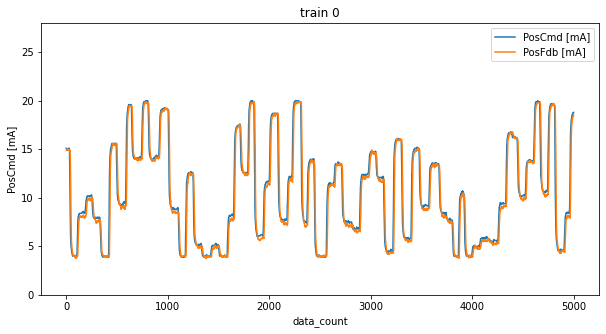

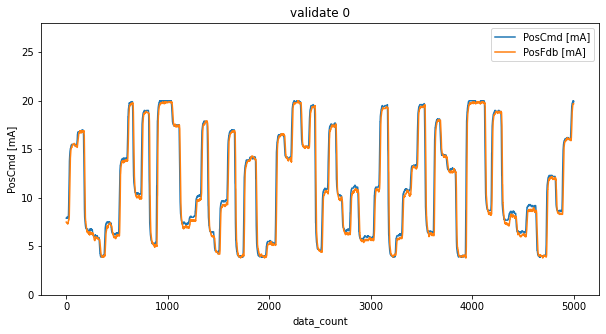

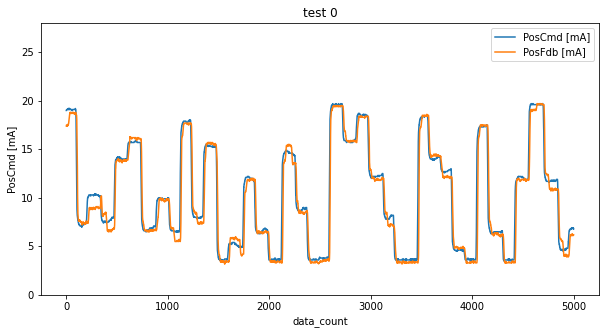

In [ ]:
# (이 소스는 2-2 에서 사용하는 변수를 활용합니다.)
# 각 파일당 5000개의 데이터가 있습니다.
# 그래서 그에 맞게 데이터들을 그래프로 출력하였습니다.

# 그래프 출력량을 줄이기 위해 일부러 1개만 출력했습니다. 
# 더 많은 그래프를 출력하려면 for i in range(1) 를 주석처리하고
# for i in rnage(int...) 부분을 주석해제하세요.

def file_graph_output(target_data=train_data, tilte='train'):
  """
  target_data: 입력할 데이터(train_data, validate_data, test_data 중 1개)
  title: 그래프에 출력할 타이틀 이름
  """
  # for i in range(int(len(target_data) / 5000)):
  for i in range(1):
    # 5000개 단위로 출력해야 하므로, 따로 인덱스를 저장하는 변수를 만들었습니다.
    start_position = 5000 * i
    end_position = 5000 * (i + 1)

    # 그리고 각 변수에 데이터를 입력했습니다.
    poscmd = target_data['PosCmd [mA]'][start_position:end_position]
    posfdb = target_data['PosFdb [mA]'][start_position:end_position]

    # 플롯 옵션 설정
    plt.figure(figsize=(10,5))
    plt.xlabel('data_count')
    plt.ylabel('PosCmd [mA]')
    plt.title('{0} {1}'.format(tilte, i))
    plt.ylim([0,28])
    # plt.plot(poscmd, label='PosCmd [mA]', color='blue')
    # plt.plot(posfdb, label='PosFdb [mA]', color='red')
    plt.plot(poscmd, label='PosCmd [mA]')
    plt.plot(posfdb, label='PosFdb [mA]')
    plt.legend()
    plt.show()


file_graph_output(train_data, 'train')
file_graph_output(validate_data, 'validate')
file_graph_output(test_data, 'test')


In [ ]:
# 이 코드는 2-1 코드를 사용해야 사용할 수 있는 코드입니다.
# 현재는 사용하지 않습니다.

# 불러온 데이터의 그래프를 출력합니다.
print("정상그래프 입니다.")
for i in range(1, (len(normal_file_list)+1)):
  file_normal = pd.read_csv(f'./normal/'+normal_file_list[i-1], encoding='cp949')
  plt.figure(figsize=(10,5))
  plt.xlabel('Time;Seq')
  plt.ylabel('PosCmd [mA]')
  plt.title(normal_file_list[i-1])
  plt.ylim([0,28])
  plt.plot(file_normal['PosCmd [mA]'], label='PosCmd [mA]')
  plt.plot(file_normal['PosFdb [mA]'], label='PosFdb [mA]')
  plt.legend()
  plt.savefig(f'{normal_file_list[i-1]}.png')
  plt.show()

print("비정상 그래프 입니다.")
for i in range(1, (len(abnormal_file_list)+1)):
  file_abnormal = pd.read_csv(f'./abnormal/'+abnormal_file_list[i-1], encoding='cp949')
  plt.figure(figsize=(10,5))
  plt.xlabel('Time;Seq')
  plt.ylabel('PosCmd [mA]')
  plt.title(abnormal_file_list[i-1])
  plt.ylim([0,28])
  plt.plot(file_abnormal['PosCmd [mA]'], label='PosCmd [mA]')
  plt.plot(file_abnormal['PosFdb [mA]'], label='PosFdb [mA]')
  plt.legend()
  plt.savefig(f'./{abnormal_file_list[i-1]}.png')
  plt.show()

정상그래프 입니다.


NameError: ignored

# 3-1. 데이터셋 생성, 데이터를 텐서로 변환, 행렬의 수정

In [ ]:
# 데이터를 텐서로 변환합니다. (클래스 내에 함수가 합쳐졌습니다.)
# 코드 보존을 위해서 주석처리하겠습니다.
# def tensortranspose(dataframe):

#   #오버샘플링
#   nam=len(dataframe)%(255*30)
#   dataframe_over=dataframe.append(dataframe[:((255*30)-(nam))])

#   #텐서로 변환해줍니다. 
#   tensor_transpose = torch.tensor(dataframe_over.values)

#   #차원을 변경해줍니다.
#   tensor_transpose_dim = tensor_transpose.view(-1,30,2).clone().detach()

#   #type을 변경해줍니다.
#   tensor_transpose_dim=((tensor_transpose_dim - 4) / 16).float()

#   #변환된 값을 반환해줍니다.
#   return tensor_transpose_dim

# 데이터셋 클래스
# 데이터셋을 생성하기 위해서 2-2의 코드가 필요합니다.
class CustomDataSetDiffrent(Dataset):
  def __init__(self, type='train'):
    typelist = ['train', 'validate', 'test']

    if (type in typelist):
      self.type = type 
    else:
      raise Exception('CustomDataSet의 type 에 넣을 수 있는 값은 train, validate, test 입니다.')

    if self.type == 'train':
      self.x_data = train_data
    elif self.type == 'validate':
      self.x_data = validate_data
    elif self.type == 'test':
      self.x_data = test_data

    self.x_data = self.tensor_proprocess(self.x_data)

  # tensortransport
  def tensor_proprocess(self, df_target):
    # 오버샘플링: 255 * 30 을 하고 나머지만큼 데이터프레임의 내용을 추가
    # mod: 나머지
    mod = len(df_target) % (255 * 30)
    df_over = df_target.append(df_target[:(255 * 30) - (mod)])

    #텐서로 변환해줍니다. 
    tensor_transpose = torch.tensor(df_over.values)

    #차원을 변경해줍니다.
    tensor_transpose_change = tensor_transpose.view(-1,30,2).clone().detach()

    #type을 변경해줍니다.
    tensor_transpose_change_float = ((tensor_transpose_change - 4) / 16).float()

    #변환된 값을 반환해줍니다.
    return tensor_transpose_change_float

  def __len__ (self):
    return len(self.x_data)

  def __getitem__ (self, idx):
    return self.x_data[idx]

# 데이터셋을 생성합니다.
train_dataset = CustomDataSetDiffrent(type='train')
validate_dataset = CustomDataSetDiffrent(type='validate')
test_dataset = CustomDataSetDiffrent(type='test')

# 3-2. 데이터로더 생성, 학습에 대한 옵션 설정(배치사이즈, 학습률)

In [ ]:
batch_size = 255 # 배치 사이즈
learning_rate = 0.01 # 학습률
# epoch_count = 30 # 에폭 수: 이 변수는 학습할 때 정의합니다. 이 시점에서 선언하지 않습니다.
# hidden_size = 30 # ?

# 디바이스 설정(cpu인가 cuda(gpu)인가 구분)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 데이터로더를 생성합니다.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
validate_loader = torch.utils.data.DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#4-1. 인코더, 디코더 클래스, 손실함수 및 옵티마이저 설정

In [ ]:
class MiraeAutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    # 원한다면... 여러분이 원하는 레이어 구조를 사용할 수 있습니다.
    # 단 입력층과 출력층의 개수가 동일해야 하며, 
    # 행렬곱을 사용할 수 있어야 하고, 배열의 형태가 동일해야 합니다.

    # 인코더는 순차 레이어로 표현했습니다.
    # Flatten -> 60 -> 30 -> 15 -> 8
    self.encoder = nn.Sequential(
      nn.Flatten(),
      nn.Linear(60, 30),
      nn.Linear(30, 15),
      nn.Linear(15, 8)
    )
    
    # 디코더는 인코딩의 반대 과정을 거칩니다.
    # 8 -> 15 -> 30 -> 60 -> Sigmoid
    self.decoder = nn.Sequential(
      nn.Linear(8, 15),
      nn.Linear(15, 30),
      nn.Linear(30, 60),
      nn.Sigmoid(),
    )

  def forward(self, x):
    x = torch.tensor(x) # 이것은 x 값을 텐서로 변환하기 위한 함수입니다.
    x = x.float() # mse 계산에는 float 값을 사용해야 하기 때문에 float으로 강제로 형변환 합니다.
    encodeData = self.encoder(x) # x 값을 인코딩 합니다.
    decodeData = self.decoder(encodeData) # 인코드데이터를 디코딩합니다.
    decodeData = decodeData.reshape(255, 30, 2) # 배열을 원래 형태로 복원합니다.
    return decodeData # 디코딩한 결과를 리턴합니다.

mirae_auto_encoder = MiraeAutoEncoder()

# 손실 함수와 옵티마이저를 설정합니다.
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(mirae_auto_encoder.parameters(), 0.001)

In [ ]:
# 오토인코더의 구조를 출력합니다.
print(mirae_auto_encoder)

MiraeAutoEncoder(
  (encoder): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=60, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=15, bias=True)
    (3): Linear(in_features=15, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=15, bias=True)
    (1): Linear(in_features=15, out_features=30, bias=True)
    (2): Linear(in_features=30, out_features=60, bias=True)
    (3): Sigmoid()
  )
)


# 5-1. 오토인코더 학습

In [ ]:
# 에폭 수(여기서 정의하는 이유는 다른곳에 정의하면 헷갈려서 그런겁니다.)
epoch_count = 38

# 반복문을 통해, 학습을 시도합니다. 에폭 수만큼
# 참고로 이 코드를 여러번 사용할 경우 학습량이 누적되어서 점점 과대적합이 될 수 있습니다.
for i in range(epoch_count):
  for j, data in enumerate(train_loader):
    # 여기서 j는 index 이고, data는 데이터입니다.
    train_result = mirae_auto_encoder(data) # 오토인코더로 학습한 데이터를 변수로 받아옵니다.
    data = data.float() # mse loss를 계산할 때 float형을 사용해야 하기 때문에 강제로 float으로 형변환합니다.

    # 한번 데이터를 처리할 때마다 해당하는 과정을 거칩니다.
    optimizer.zero_grad() # 가중치 초기화
    loss = loss_function(train_result, data) # 손실값 계산
    loss.backward() # 모든 가중치 계산 및 미분
    optimizer.step() # 저장된 매개변수 값을 이용해 매개변수 업데이트

  # 1 에폭이 끝나면 손실 값을 출력합니다.
  print(loss)

# 모델 파일을 저장합니다.
torch.save(mirae_auto_encoder, 'mirea_auto_encoder.pth')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(0.0029, grad_fn=<MseLossBackward>)
tensor(0.0029, grad_fn=<MseLossBackward>)
tensor(0.0029, grad_fn=<MseLossBackward>)
tensor(0.0029, grad_fn=<MseLossBackward>)
tensor(0.0029, grad_fn=<MseLossBackward>)
tensor(0.0029, grad_fn=<MseLossBackward>)
tensor(0.0029, grad_fn=<MseLossBackward>)
tensor(0.0029, grad_fn=<MseLossBackward>)
tensor(0.0029, grad_fn=<MseLossBackward>)
tensor(0.0029, grad_fn=<MseLossBackward>)
tensor(0.0029, grad_fn=<MseLossBackward>)
tensor(0.0029, grad_fn=<MseLossBackward>)
tensor(0.0028, grad_fn=<MseLossBackward>)
tensor(0.0028, grad_fn=<MseLossBackward>)
tensor(0.0028, grad_fn=<MseLossBackward>)
tensor(0.0027, grad_fn=<MseLossBackward>)
tensor(0.0027, grad_fn=<MseLossBackward>)
tensor(0.0026, grad_fn=<MseLossBackward>)
tensor(0.0024, grad_fn=<MseLossBackward>)
tensor(0.0023, grad_fn=<MseLossBackward>)
tensor(0.0021, grad_fn=<MseLossBackward>)
tensor(0.0020, grad_fn=<MseLossBackward>)
tensor(0.0020, grad_fn=<MseLossBackward>)
tensor(0.0020, grad_fn=<MseLossBac

# 6-1. 데이터 복원 및 rec.error 값 계산, rec.error값 추가

In [ ]:
# 데이터를 좀 더 편하게 보기 위해, 원래 형태랑 비슷하게 복원합니다.
# 데이터셋을 만드는 과정에서 전처리 할 때 배열이 일부 변형되면서 추가로 배열의 형태가 (255, 30, 2) 로 변형되었고,
# 데이터로더를 만드는 과정에서 배치사이즈만큼 총 데이터가 나누어졌습니다.
dataframe = pd.DataFrame(columns=['PosCmd [mA]', 'PosFdb [mA]', 'rec.error'])
def data_recovery(data_loader=train_loader, autoencoder=False, denormalization=False):
  """
  데이터셋을 원본 데이터 형태로 복원합니다.
  데이터셋으로 만들어지는 과정에서 배열 구조가 손상되므로 모든 데이터가 되돌아오지 않습니다.
  data_loader = 데이터로더(train_loader, validate_loader, test_loader 중 1개)
  autoencoder = 오토인코더 작업을 할 것인가? True일경우 디코딩 된 결과를 얻어옵니다.
  denormalization = 반정규화? True일경우 정규화되기 전의 값을 보여줍니다.
  """
  # 원본형태의 데이터프레임
  dataframe = pd.DataFrame(columns=['PosCmd [mA]', 'PosFdb [mA]', 'rec.error'], index=None)

  for i, data in enumerate(data_loader):
    loop_dataframe = pd.DataFrame(columns=['PosCmd [mA]', 'PosFdb [mA]', 'rec.error'])

    # 오토인코더로 학습할것인지 확인
    if(autoencoder):
      getdata = mirae_auto_encoder(data)
    else:
      getdata = data
    
    # 배열을 원래 형태로 변경합니다.
    getdata = getdata.reshape(-1, 2)
    getdata = getdata.detach().numpy()

    # 그리고 각 데이터프레임에 데이터를 삽입합니다.
    loop_dataframe['PosCmd [mA]'] = getdata[:, 0]
    loop_dataframe['PosFdb [mA]'] = getdata[:, 1]

    # 데이터프레임에 새로운 데이터프레임의 내용을 추가합니다.
    dataframe = dataframe.append(loop_dataframe, ignore_index=True, verify_integrity=True)

  # 반정규화 옵션
  if(denormalization):
    dataframe = (dataframe * 16) + 4
    dataframe = dataframe.round(2)

  # poscmd와 posfdb의 차이값인 rec.error값을 계산합니다.
  dataframe['rec.error'] = abs(dataframe['PosCmd [mA]'] - dataframe['PosFdb [mA]'])
  return dataframe

# 셀을 한번만 실행하기 위해 이 함수를 한 개의 셀에 넣었습니다.
# rec.error 값만 추가할거면 이 함수를 추가하세요.
def add_rec_error(target_dataframe):
  """
  이 함수는 데이터가 있는 데이터프레임을 매개변수로 넣는다면
  rec.error행이 추가된 새로운 데이터프레임을 리턴합니다.
  """
  new_dataframe = pd.DataFrame(columns=['PosCmd [mA]', 'PosFdb [mA]', 'rec.error'])
  new_dataframe['PosCmd [mA]'] = target_dataframe['PosCmd [mA]']
  new_dataframe['PosFdb [mA]'] = target_dataframe['PosFdb [mA]']
  new_dataframe['rec.error'] = abs(target_dataframe['PosCmd [mA]'] - target_dataframe['PosFdb [mA]'])
  return new_dataframe

# 6-2. 오차행렬 계산

In [ ]:
# 오차행렬을 계산하고 객체를 리턴합니다.
# 코드는 현희님의 것을 참고했습니다.
# 변수 이름 충돌 문제가 있으므로, 함수 매개변수의 이름을 변경해주세요.
# 오류 원인은 알 수 없으나, 함수 매개변수가 전역변수로 취급되고 이름 충돌이 발생하는것으로 보입니다.
def confusion_matrix(df_nor, df_abn, threshold=0.25, view=False):
  """
  오차행렬을 계산한 후 그에 대한 결과를 딕셔너리로 리턴합니다.
  dataframe에는 'rec.error'행이 존재해야 합니다.
  not define 오류가 발생하는경우, 매개변수 이름으로 된 전역변수를 생성하세요.
  data_recovery 함수를 사용해주세요.
  df_nor: 정상 값이 들어있는 데이터프레임(validate)을 넣어주세요.
  df_abn: 비정상 값이 들어있는 데이터프레임(test)를 넣어주세요.
  view: 행렬 값과 기타 정보를 print로 출력합니다.
  """
         # 실제파일 : 임계값 >> 임계값이 높으면 abnormal입니다.
  TP = 0 # abnromal > threshold >> 실제값이 abnormal인데 True(abnormal로 판단 정답)
  TN = 0 # normal <= threshold >> 실제값이 normal인데 True(normal로 판단 정답)
  FP = 0 # normal > threshold >> 실제값이 normal인데 False(abnormal로 판단해서 틀림) 
  FN = 0 # abnormal <= threshold >> 실제값이 abnormal인데 False(normal로 판단해서 틀림)

  # 단순하게 계산하기 위해 데이터프레임에서 조건에 맞는 행 수만큼 바로 변수에 대입했습니다.
  TP = len(df_abn[df_abn['rec.error'] > threshold])
  TN = len(df_nor[df_nor['rec.error'] <= threshold])
  FP = len(df_nor[df_nor['rec.error'] > threshold])
  FN = len(df_abn[df_abn['rec.error'] <= threshold])

  # 0 으로 나눗셈 되는 오류를 해결하기 위해 0 으로 나눌 수 없도록 했습니다.
  if (TP + FP == 0): precision = 0 
  else: precision = TP / (TP + FP) # 정밀도
  if (TP + TN + FN + FP == 0): accuracy = 0
  else: accuracy = (TN + TP) / (TP + TN + FN + FP) # 정확도
  if (TP + FN == 0): recall = 0 
  else: recall = TP / (TP + FN) # 재현률 = 민감도
  if (FP + TN == 0): specificity = 0 
  else: specificity = TN / (FP + TN) # 특이도
  if (precision + recall == 0): f1score = 0 
  else: f1score = 2 * (precision * recall) / (precision + recall) # f1스코어
  FPR = 1 - specificity # False Positive rate(위양성): 1 - specificity
  

  if(view): # view 를 True로 하면 정보를 보여줍니다.
    print('matrix information')
    print(f'TP: {TP:5d} | FN: {FN:5d} | total(abnormal): {len(df_abn)}')
    print(f'FP: {FP:5d} | TN: {TN:5d} | total(normal): {len(df_nor)}')
    print(f"accuracy(정확도):{accuracy}")
    print(f"precision(정밀도):{precision}")
    print(f"recall(재현율):{recall}")
    print(f"specificity(특이도):{specificity}")
    print(f"FPR(1-SP):{FPR}")
    print(f"f1score:{f1score}")

  return {
    'TP':TP, 'TN':TN, 'FP':FP, 'FN':FN,
    'accuracy':accuracy,
    'precision':precision,
    'recall':recall,
    'specificity':specificity,
    'fpr':FPR,
    'f1score':f1score,
    'threshold':threshold
  }

# 함수를 사용할 수 없을경우, not defined 문제가 발생할경우
# 다음 전역변수를 선언하세요. 이유는 알 수 없음. 하지만 이렇게 해야 오류가 사라집니다.
x1 = data_recovery(validate_loader, autoencoder=False)
x2 = data_recovery(test_loader, autoencoder=False)
confusion_matrix(x1, x2, view=True)

matrix information
TP:  1618 | FN: 51932 | total(abnormal): 53550
FP:  1904 | TN: 43996 | total(normal): 45900
accuracy(정확도):0.4586626445449975
precision(정밀도):0.4593980692788189
recall(재현율):0.030214752567693744
specificity(특이도):0.9585185185185185
FPR(1-SP):0.04148148148148145
f1score:0.05670030838239417


{'FN': 51932,
 'FP': 1904,
 'TN': 43996,
 'TP': 1618,
 'accuracy': 0.4586626445449975,
 'f1score': 0.05670030838239417,
 'fpr': 0.04148148148148145,
 'precision': 0.4593980692788189,
 'recall': 0.030214752567693744,
 'specificity': 0.9585185185185185,
 'threshold': 0.25}

# 6-3. AUR/ROC 그래프

In [ ]:
# auc, roc를 구하려면 rec.error 데이터가 필요해서 해당 열을 추가하는 함수를 사용했습니다.
new_validate = data_recovery(validate_loader, False, False)
new_test = data_recovery(validate_loader, False, False)

In [ ]:
# TPR(True Positive Rate), FPR(False Positive Rate)를 저장하는 값 배열을 선언합니다.
tpr = []
fpr = []

# for문을 통해 임계값을 0부터 1까지 루프를 돌리면서 혼동행렬값을 계산해서 tpr, fpr값을 얻어냅니다.
for i in range(0, 100):
  threshold = i * 0.01
  getdata = confusion_matrix(dataframe_normal=new_validate, dataframe_abnoraml=new_test, threshold=threshold)
  tpr.append(getdata['recall'])
  fpr.append(getdata['fpr'])
  # break

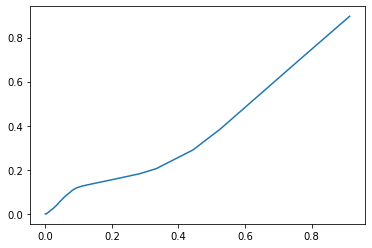

In [ ]:
plt.plot(tpr, fpr)

# 6-4. 값 그래프

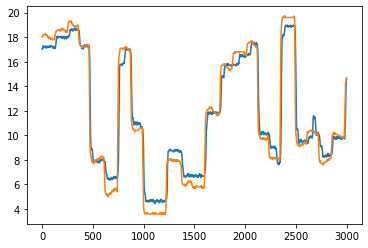

In [ ]:
plt.plot(decode_test['PosCmd [mA]'][:3000])
plt.plot(test_data['PosCmd [mA]'][:3000])

# 7-1. 다른 형태의 데이터셋 클래스와 인코더 클래스 테스트 - 주의: 변수명이 기존에 사용하는것과 서로 다릅니다.

In [ ]:
class CustomDataSetAlternative(Dataset):
  def __init__(self, type='train'):
    typelist = ['train', 'validate', 'test']

    if (type in typelist):
      self.type = type 
    else:
      raise Exception('CustomDataSet의 type 에 넣을 수 있는 값은 train, validate, test 입니다.')

    if self.type == 'train':
      self.x_data = train_data
    elif self.type == 'validate':
      self.x_data = validate_data
    elif self.type == 'test':
      self.x_data = test_data

    self.x_data = self.tensor_proprocess(self.x_data)

  # tensortransport
  def tensor_proprocess(self, df_target):
    # 오버샘플링: 255 * 30 을 하고 나머지만큼 데이터프레임의 내용을 추가
    # mod: 나머지
    mod = len(df_target) % (255 * 30)
    df_over = df_target.append(df_target[:(255 * 30) - (mod)])

    #텐서로 변환해줍니다. 
    tensor_transpose = torch.tensor(df_over.values)

    #차원을 변경해줍니다.
    tensor_transpose_change = tensor_transpose.view(-1,30,2).clone().detach()

    #type을 변경해줍니다.
    tensor_transpose_change_float = ((tensor_transpose_change - 4) / 16).float()

    #변환된 값을 반환해줍니다.
    return tensor_transpose_change_float

  def __len__ (self):
    return len(self.x_data)

  def __getitem__ (self, idx):
    return self.x_data[idx]

# 데이터셋을 생성합니다.
train_alter = CustomDataSetAlternative(type='train')
validate_alter = CustomDataSetAlternative(type='validate')
test_alter = CustomDataSetAlternative(type='test')

In [ ]:
batch_size = 5000 # 배치 사이즈
learning_rate = 0.01 # 학습률
# epoch_count = 30 # 에폭 수: 이 변수는 학습할 때 정의합니다. 이 시점에서 선언하지 않습니다.
# hidden_size = 30 # ?

# 디바이스 설정(cpu인가 cuda(gpu)인가 구분)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 데이터로더를 생성합니다.
train_alter_loader = torch.utils.data.DataLoader(train_alter, batch_size=batch_size, shuffle=False)
validate_alter_loader = torch.utils.data.DataLoader(validate_alter, batch_size=batch_size, shuffle=False)
test_alter_loader = torch.utils.data.DataLoader(test_alter, batch_size=batch_size, shuffle=False)

In [ ]:
class MiraeAutoEncoderAlternative(nn.Module):
  def __init__(self):
    super().__init__()
    # 원한다면... 여러분이 원하는 레이어 구조를 사용할 수 있습니다.
    # 단 입력층과 출력층의 개수가 동일해야 하며, 행렬곱을 사용할 수 있어야 하고, 배열의 형태가 동일해야 합니다.

    # 인코딩과 디코딩
    self.encoder = nn.Sequential(
      nn.Flatten(),
      nn.Linear(2, 1),
    )
    self.decoder = nn.Sequential(
      nn.Linear(1, 2),
      # nn.Sigmoid(),
    )

  def forward(self, x):
    x = torch.tensor(x) # 이것은 x 값을 텐서로 변환하기 위한 함수입니다.
    x = x.float() # mse 계산에는 float 값을 사용해야 하기 때문에 float으로 강제로 형변환 합니다.
    encodeData = self.encoder(x) # x 값을 인코딩 합니다.
    decodeData = self.decoder(encodeData) # 인코드데이터를 디코딩합니다.
    # decodeData = decodeData.reshape(255, 30, 2) # 배열을 원래 형태로 복원합니다.
    return decodeData # 디코딩한 결과를 리턴합니다.

mirae_auto_encoder_alter = MiraeAutoEncoderAlternative()

# 손실 함수와 옵티마이저를 설정합니다.
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(mirae_auto_encoder.parameters(), 0.001)

In [ ]:
# 에폭 수(여기서 정의하는 이유는 다른곳에 정의하면 헷갈려서 그런겁니다.)
epoch_count = 30

# 반복문을 통해, 학습을 시도합니다. 에폭 수만큼
# 참고로 이 코드를 여러번 사용할 경우 학습량이 누적되어서 점점 과대적합이 될 수 있습니다.
for i in range(epoch_count):
  for j, data in enumerate(train_loader):
    # 여기서 j는 index 이고, data는 데이터입니다.
    train_result = mirae_auto_encoder(data) # 오토인코더로 학습한 데이터를 변수로 받아옵니다.
    data = data.float() # mse loss를 계산할 때 float형을 사용해야 하기 때문에 강제로 float으로 형변환합니다.

    # 한번 데이터를 처리할 때마다 해당하는 과정을 거칩니다.
    optimizer.zero_grad() # 가중치 초기화
    loss = loss_function(train_result, data) # 손실값 계산
    loss.backward() # 모든 가중치 계산 및 미분
    optimizer.step() # 저장된 매개변수 값을 이용해 매개변수 업데이트

  # 1 에폭이 끝나면 손실 값을 출력합니다.
  print(loss)

# 모델 파일을 저장합니다.
torch.save(mirae_auto_encoder, 'mirea_auto_encoder_alter.pth')

# 7-2. 임시공간

In [ ]:
err_train = train_data.copy()
err_test = test_data.copy()

err_train = (err_train - 4) / 16
err_test = (err_test - 4) / 16

err_train = add_rec_error(err_train)
err_test = add_rec_error(err_test)

In [ ]:
err_train['rec.error'].mean()

0.044373750000011036

In [ ]:
err_test['rec.error'].mean()

0.04826499999999711

In [ ]:
confusion_matrix(err_train, err_test, 0.44, True)

matrix information
TP:   449 | FN: 49568 | total(abnormal): 53550
FP:  1335 | TN: 158665 | total(normal): 160000
accuracy(정확도):0.75762438278806
precision(정밀도):0.25168161434977576
recall(재현율):0.00897694783773517
specificity(특이도):0.99165625
FPR(1-SP):0.008343749999999983
f1score:0.01733557267234223


{'FN': 49568,
 'FP': 1335,
 'TN': 158665,
 'TP': 449,
 'accuracy': 0.75762438278806,
 'f1score': 0.01733557267234223,
 'fpr': 0.008343749999999983,
 'precision': 0.25168161434977576,
 'recall': 0.00897694783773517,
 'specificity': 0.99165625,
 'threshold': 0.44}

In [ ]:
rec_validate_auto = data_recovery(train_loader, True)
rec_validate = data_recovery(train_loader, False)
rec_test_auto = data_recovery(test_loader, True)
rec_test = data_recovery(test_loader, False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
print('rec_validate_auto mean_error:', rec_validate_auto['rec.error'].mean())
print('rec_validate mean_error:', rec_validate['rec.error'].mean())
print('rec_test_auto mean_error:', rec_test_auto['rec.error'].mean())
print('rec_test mean_error:', rec_test['rec.error'].mean())

rec_validate_auto mean_error: 0.04317265748977661
rec_validate mean_error: 0.04436882212758064
rec_test_auto mean_error: 0.028708361089229584
rec_test mean_error: 0.0477769672870636


# 7-3. 임시공간, 7-1의 사본?

In [ ]:
class CustomDataSetNoPreprocess(Dataset):
  def __init__(self, type='train'):
    typelist = ['train', 'validate', 'test']

    if (type in typelist):
      self.type = type 
    else:
      raise Exception('CustomDataSet의 type 에 넣을 수 있는 값은 train, validate, test 입니다.')

    if self.type == 'train':
      self.x_data = train_data
    elif self.type == 'validate':
      self.x_data = validate_data
    elif self.type == 'test':
      self.x_data = test_data

  def __len__ (self):
    return len(self.x_data)

  def __getitem__ (self, idx):
    return self.x_data[idx]

# 데이터셋을 생성합니다.
train_nopre = CustomDataSetNoPreprocess(type='train')
validate_nopre = CustomDataSetNoPreprocess(type='validate')
test_nopre = CustomDataSetNoPreprocess(type='test')